In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-cnn/pytorch-cnn.zip
!unzip -qq pytorch-cnn.zip
%cd pytorch-cnn

--2023-10-24 01:36:28--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-cnn/pytorch-cnn.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.82.132, 52.92.241.2, 3.5.82.125, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.82.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1771768 (1.7M) [binary/octet-stream]
Saving to: ‘pytorch-cnn.zip’

pytorch-cnn.zip     100%[===================>]   1.69M  3.92MB/s    in 0.4s    

2023-10-24 01:36:29 (3.92 MB/s) - ‘pytorch-cnn.zip’ saved [1771768/1771768]

/content/pytorch-cnn


In [ ]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch import flatten
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [ ]:
class LeNet(Module):
  def __init__(self, numChannels, classes):
    super(LeNet, self).__init__()
    self.conv1 = Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
    self.relu1 = ReLU()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = ReLU()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.fc1 = Linear(in_features=800, out_features=500)
    self.relu3 = ReLU()

    self.fc2 = Linear(in_features=500, out_features=classes)
    self.logSoftmax = LogSoftmax(dim=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    x = self.fc2(x)

    output = self.logSoftmax(x)

    return output



In [ ]:
init_lr = 1e-3
batch_size = 64
epochs = 10

train_split = 0.75
val_split = 1-train_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trainData = KMNIST(root = "data", train=True, download=True,
                   transform=ToTensor())
testData = KMNIST(root = "data", train = False, download=True,
                  transform=ToTensor())

numTrainSamples = int(len(trainData) * train_split)
numValSamples = int(len(trainData) * val_split)

(trainData, valData) = random_split(trainData,
                                    [numTrainSamples, numValSamples],
                                    generator = torch.Generator().manual_seed(42))

100%|██████████| 18165135/18165135 [00:16<00:00, 1118608.89it/s]


Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 184148.70it/s]


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:03<00:00, 817403.17it/s]


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 19647608.86it/s]


Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw



In [ ]:
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=batch_size)
valDataLoader = DataLoader(valData, batch_size =batch_size)
testDataLoader = DataLoader(testData, batch_size =batch_size)

trainSteps = len(trainDataLoader.dataset)//batch_size
valSteps = len(valDataLoader.dataset) // batch_size

In [ ]:
model = LeNet(
    numChannels=1,
    classes=len(trainData.dataset.classes)).to(device)

opt = Adam(model.parameters(), lr= init_lr)
lossFn = nn.NLLLoss()

H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [ ]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, epochs):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))

		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)

		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))

			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, epochs))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.243114, Train accuracy: 0.9259
Val loss: 0.147889, Val accuracy: 0.9548

[INFO] EPOCH: 2/10
Train loss: 0.086953, Train accuracy: 0.9737
Val loss: 0.085194, Val accuracy: 0.9743

[INFO] EPOCH: 3/10
Train loss: 0.053473, Train accuracy: 0.9835
Val loss: 0.068562, Val accuracy: 0.9803

[INFO] EPOCH: 4/10
Train loss: 0.034531, Train accuracy: 0.9896
Val loss: 0.071214, Val accuracy: 0.9789

[INFO] EPOCH: 5/10
Train loss: 0.022074, Train accuracy: 0.9927
Val loss: 0.069275, Val accuracy: 0.9795

[INFO] EPOCH: 6/10
Train loss: 0.018441, Train accuracy: 0.9944
Val loss: 0.078232, Val accuracy: 0.9789

[INFO] EPOCH: 7/10
Train loss: 0.014194, Train accuracy: 0.9954
Val loss: 0.077999, Val accuracy: 0.9819

[INFO] EPOCH: 8/10
Train loss: 0.013360, Train accuracy: 0.9958
Val loss: 0.092038, Val accuracy: 0.9786

[INFO] EPOCH: 9/10
Train loss: 0.012251, Train accuracy: 0.9959
Val loss: 0.076819, Val accuracy: 0.9834

[INFO] EPOCH: 1

In [ ]:
with torch.no_grad():
  model.eval()
  preds = []

  for (x, y) in testDataLoader:
    x = x.to(device)

    pred = model(x)
    preds.extend(pred.argmax(axis=1).cpu().numpy())

  print(classification_report(testData.targets.cpu().numpy(),
                              np.array(preds), target_names=testData.classes))

              precision    recall  f1-score   support

           o       0.94      0.97      0.95      1000
          ki       0.99      0.91      0.95      1000
          su       0.94      0.90      0.92      1000
         tsu       0.97      0.96      0.97      1000
          na       0.93      0.94      0.94      1000
          ha       0.96      0.94      0.95      1000
          ma       0.90      0.98      0.94      1000
          ya       0.98      0.92      0.95      1000
          re       0.95      0.97      0.96      1000
          wo       0.90      0.98      0.93      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



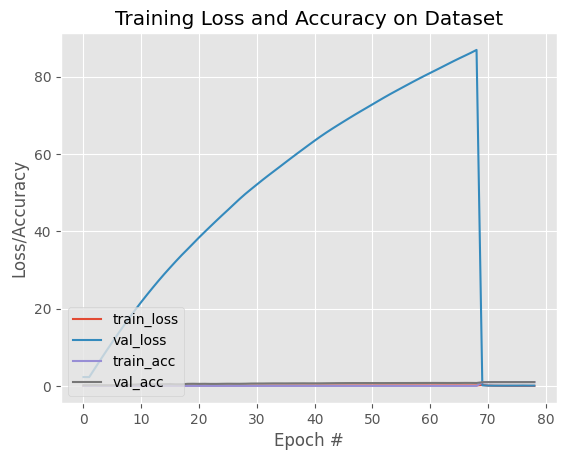

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()